# Homework #3: Fashion MNIST CNN 분류

**목표: Test Accuracy 94% 이상 달성하기**

---

## 필요한 라이브러리 임포트

In [23]:
!pip install torchinfo

In [24]:
import os
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms

import wandb

# Jupyter Notebook에서 그래프를 inline으로 표시
%matplotlib inline

## 설정 및 하이퍼파라미터 정의

주피터 노트북에서는 가독성을 위해서 argparse 대신 설정 클래스를 만들어 사용하도록 했습니다.
튜닝을 마친 설정값입니다.

In [25]:
class Config:
    """학습에 필요한 모든 하이퍼파라미터를 설정하는 클래스"""

    # WandB 설정
    wandb_enabled = True

    # 기본 학습 파라미터 (최적화된 값)
    batch_size = 128          # 배치 크기
    epochs = 100              # 최대 에폭 수
    learning_rate = 0.0005    # 학습률

    # 검증 및 조기 종료 설정
    validation_intervals = 1   # 검증 간격
    early_stop_patience = 25   # Early Stopping Patience
    early_stop_delta = 0.001   # Early Stopping Delta

    # 정규화 파라미터 (과적합 방지)
    weight_decay = 1e-4       # L2 Regularization (Weight Decay)
    dropout_p = 0.5           # Dropout 확률

    # 학습률 스케줄러 설정
    scheduler_step = 10       # StepLR step size
    scheduler_gamma = 0.5     # StepLR gamma

    # 데이터 증강 (Data Augmentation) 옵션
    use_horizontal_flip = True
    horizontal_flip_p = 0.5
    use_random_affine = True
    affine_translate = 0.1

# 설정 객체 생성
args = Config()

print("=" * 50)
print("학습 설정 (Best Run Configuration)")
print("=" * 50)
print(f"Batch Size: {args.batch_size}")
print(f"Learning Rate: {args.learning_rate}")
print(f"Epochs: {args.epochs}")
print(f"Dropout: {args.dropout_p}")
print(f"Weight Decay: {args.weight_decay}")
print(f"Early Stop Patience: {args.early_stop_patience}")
print(f"Early Stop Delta: {args.early_stop_delta}")
print(f"Augmentation (Flip): {args.use_horizontal_flip}")
print(f"Augmentation (Affine): {args.use_random_affine}")
print("=" * 50)

학습 설정 (Best Run Configuration)
Batch Size: 128
Learning Rate: 0.0005
Epochs: 100
Dropout: 0.5
Weight Decay: 0.0001
Early Stop Patience: 25
Early Stop Delta: 0.001
Augmentation (Flip): True
Augmentation (Affine): True


## 전역 변수 및 시드 설정

In [26]:
# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Fashion MNIST 클래스 레이블
FASHION_MNIST_CLASSES = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: cuda:0


---

# 문제 1: Fashion MNIST Mean/Std 계산

데이터 정규화(Normalization)를 위해 Fashion MNIST 학습 데이터의 평균(Mean)과 표준편차(Std)를 계산합니다.

In [27]:
def calculate_fashion_mnist_mean_std():
    """
    Fashion MNIST 데이터셋의 Mean과 Std를 계산하는 함수
    학습 속도 향상을 위해 데이터 정규화에 사용할 통계값을 구함
    """
    print("\n[Pre-processing] Mean & Std 계산 중...")

    data_path = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "j_fashion_mnist")

    # Transform 없이 원본 데이터 로드
    fashion_mnist_train = datasets.FashionMNIST(
        data_path, train=True, download=True, transform=transforms.ToTensor()
    )

    # 전체 이미지를 하나로 합쳐서 계산
    imgs = torch.stack([img_t for img_t, _ in fashion_mnist_train], dim=3)

    mean = imgs.view(1, -1).mean(dim=-1)
    std = imgs.view(1, -1).std(dim=-1)

    mean_val = mean.item()
    std_val = std.item()

    print(f"  - Mean: {mean_val:.4f}")
    print(f"  - Std : {std_val:.4f}")

    return mean_val, std_val

In [28]:
# Mean과 Std 계산 실행
mean, std = calculate_fashion_mnist_mean_std()

print("\n" + "=" * 50)
print("[문제 1] Fashion MNIST 통계값")
print("=" * 50)
print(f"Mean: {mean:.6f}")
print(f"Std:  {std:.6f}")
print("=" * 50)


[Pre-processing] Mean & Std 계산 중...
  - Mean: 0.2860
  - Std : 0.3530

[문제 1] Fashion MNIST 통계값
Mean: 0.286041
Std:  0.353024


---

# 문제 2: CNN 학습

Fashion MNIST 데이터에 대하여 CNN 모델을 학습시킵니다.

## Early Stopping 클래스 정의

In [29]:
class EarlyStopping:
    """
    Early Stopping 클래스
    검증 손실(Val Loss)이 더 이상 줄어들지 않으면 학습을 멈춰서 과적합을 방지
    """
    def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
        self.patience = patience
        self.counter = 0
        self.delta = delta
        self.validation_loss_min = None

        # 모델 저장 경로 설정
        if checkpoint_file_path and project_name and run_time_str:
            self.file_path = os.path.join(checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt")
            self.latest_file_path = os.path.join(checkpoint_file_path, f"{project_name}_checkpoint_latest.pt")
        else:
            self.file_path = "checkpoint_best.pt"
            self.latest_file_path = "checkpoint_latest.pt"

    def check_and_save(self, new_validation_loss, model):
        early_stop = False
        message = ""

        if self.validation_loss_min is None:
            self.validation_loss_min = new_validation_loss
            message = 'Early stopping 시작'

        elif new_validation_loss < self.validation_loss_min - self.delta:
            # 성능이 개선됨 -> 모델 저장
            message = f'Val loss 개선 ({self.validation_loss_min:.5f} --> {new_validation_loss:.5f}). 저장 중...'
            self.save_checkpoint(new_validation_loss, model)
            self.validation_loss_min = new_validation_loss
            self.counter = 0
        else:
            # 개선 안됨 -> 카운트 증가
            self.counter += 1
            message = f'Early stopping 카운터: {self.counter}/{self.patience}'
            if self.counter >= self.patience:
                early_stop = True
                message += " [학습 종료]"

        return message, early_stop

    def save_checkpoint(self, validation_loss, model):
        torch.save(model.state_dict(), self.file_path)
        torch.save(model.state_dict(), self.latest_file_path)
        self.validation_loss_min = validation_loss

## 데이터 로더 생성

In [30]:
def get_fashion_mnist_data(mean, std, use_horizontal_flip=True, horizontal_flip_p=0.5, use_random_affine=True,
                           affine_translate=0.1):
    """Fashion MNIST 학습/검증 데이터 로더 생성"""
    data_path = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "j_fashion_mnist")

    # 전체 데이터셋
    f_mnist_train_full = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())

    # 학습(55k) / 검증(5k) 분리
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train_full, [55_000, 5_000])

    # 학습용 변환 (Data Augmentation 적용)
    train_transform_list = [
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=mean, std=std),
    ]

    # 일반화 성능을 높이기 위해 이미지 변형 추가
    if use_horizontal_flip:
        train_transform_list.append(transforms.RandomHorizontalFlip(p=horizontal_flip_p))
    if use_random_affine:
        train_transform_list.append(transforms.RandomAffine(degrees=0, translate=(affine_translate, affine_translate)))

    train_transforms = nn.Sequential(*train_transform_list)

    # 검증용 변환 (정규화만)
    validation_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=mean, std=std),
    )

    train_data_loader = DataLoader(
        dataset=f_mnist_train,
        batch_size=args.batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=2,
        drop_last=True
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation,
        batch_size=args.batch_size,
        pin_memory=True,
        num_workers=2,
        drop_last=True
    )

    return train_data_loader, validation_data_loader, train_transforms, validation_transforms


def get_fashion_mnist_test_data(mean, std):
    """Fashion MNIST 테스트 데이터 로더 생성"""
    data_path = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "j_fashion_mnist")

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=args.batch_size)

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=mean, std=std),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

## CNN 모델 정의 (Wider CNN Architecture)

**핵심 아이디어:**
- 기본 CNN보다 채널 수를 늘린 구조 (64 → 128 → 256)
- 파라미터 수는 증가하지만 복잡한 특징을 더 잘 학습
- Batch Normalization으로 학습 안정화
- Dropout으로 과적합 방지

In [31]:
def get_cnn_model(dropout_p=0.4):
    """
    Wider CNN 모델 생성
    기본 CNN보다 채널 수를 늘려서 표현력을 높인 모델
    """

    class MyModel(nn.Module):
        def __init__(self, in_channels, n_output):
            super().__init__()

            self.model = nn.Sequential(
                # Block 1: 첫 번째 Convolution 블록
                nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),  # Batch Normalization으로 학습 안정화
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.MaxPool2d(kernel_size=2, stride=2),  # 이미지 크기 축소 (28x28 -> 14x14)
                nn.ReLU(),

                # Block 2: 채널 확장 (64 -> 128)
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.MaxPool2d(kernel_size=2, stride=2),  # 이미지 크기 축소 (14x14 -> 7x7)
                nn.ReLU(),

                # Block 3: 채널 확장 (128 -> 256)
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.MaxPool2d(kernel_size=2, stride=2),  # 이미지 크기 축소 (7x7 -> 3x3)
                nn.ReLU(),

                # Classifier: 분류를 위한 Fully Connected Layer
                nn.Flatten(),
                nn.Linear(256 * 3 * 3, 512),
                nn.ReLU(),
                nn.Dropout(dropout_p),  # 과적합 방지를 위한 Dropout
                nn.Linear(512, n_output),
            )

        def forward(self, x):
            return self.model(x)

    return MyModel(in_channels=1, n_output=10)

## 학습 클래스 정의

In [32]:
class ClassificationTrainer:
    """
    CNN 모델의 학습 및 검증 전 과정을 담당하는 클래스.
    에폭(Epoch) 단위의 루프를 돌며 학습(Train)과 검증(Validation)을 수행하고,
    WandB 로깅 및 조기 종료(Early Stopping) 기능을 관리합니다.
    """

    def __init__(self, project_name, model, optimizer, scheduler, train_data_loader, validation_data_loader,
                 train_transforms, validation_transforms, run_time_str, wandb, device, checkpoint_file_path):
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.train_transforms = train_transforms
        self.validation_transforms = validation_transforms
        self.run_time_str = run_time_str
        self.wandb = wandb
        self.device = device
        self.checkpoint_file_path = checkpoint_file_path

        # 다중 클래스 분류 문제이므로 CrossEntropyLoss 사용
        self.loss_fn = nn.CrossEntropyLoss()

    def do_train(self):
        """
        1 에폭 동안 훈련 데이터를 사용하여 모델을 학습시키는 함수.
        """
        # [중요] 모델을 학습 모드로 전환 (Dropout, BatchNorm 등이 학습 모드로 동작하게 함)
        self.model.train()

        loss_train = 0.0
        num_corrects_train = 0
        num_trained_samples = 0
        num_trains = 0

        # 미니 배치 단위로 학습 진행
        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch
            # 데이터를 GPU(또는 설정된 device)로 이동
            input_train = input_train.to(device=self.device)
            target_train = target_train.to(device=self.device)

            # 학습 데이터 증강(Augmentation) 적용 (설정된 경우)
            if self.train_transforms:
                input_train = self.train_transforms(input_train)

            # 1. 순전파 (Forward Pass): 모델에 입력을 넣어 예측값 산출
            output_train = self.model(input_train)
            loss = self.loss_fn(output_train, target_train)
            loss_train += loss.item()

            # 정확도 계산을 위한 예측 라벨 추출
            predicted_train = torch.argmax(output_train, dim=-1)
            num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

            num_trained_samples += len(input_train)
            num_trains += 1

            # [핵심 학습 단계] 역전파 및 가중치 갱신
            self.optimizer.zero_grad()  # 이전 배치의 그래디언트가 누적되지 않도록 초기화
            loss.backward()             # 손실에 대한 그래디언트 계산 (역전파)
            self.optimizer.step()       # 계산된 그래디언트를 사용하여 모델 파라미터 업데이트

        train_loss = loss_train / num_trains
        train_accuracy = 100.0 * num_corrects_train / num_trained_samples

        return train_loss, train_accuracy

    def do_validation(self):
        """
        검증 데이터를 사용하여 모델의 성능을 평가하는 함수.
        학습(가중치 업데이트)은 일어나지 않음.
        """
        # [중요] 모델을 평가 모드로 전환 (Dropout 비활성화, BatchNorm 통계값 고정)
        self.model.eval()

        loss_validation = 0.0
        num_corrects_validation = 0
        num_validated_samples = 0
        num_validations = 0

        # [중요] 그래디언트 계산 비활성화 (메모리 절약 및 연산 속도 향상)
        with torch.no_grad():
            for validation_batch in self.validation_data_loader:
                input_validation, target_validation = validation_batch
                input_validation = input_validation.to(device=self.device)
                target_validation = target_validation.to(device=self.device)

                # 검증 데이터 전처리 (일반적으로 정규화만 수행)
                if self.validation_transforms:
                    input_validation = self.validation_transforms(input_validation)

                # 순전파 및 손실 계산
                output_validation = self.model(input_validation)
                loss_validation += self.loss_fn(output_validation, target_validation).item()

                predicted_validation = torch.argmax(output_validation, dim=1)
                num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

                num_validated_samples += len(input_validation)
                num_validations += 1

        validation_loss = loss_validation / num_validations
        validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

        return validation_loss, validation_accuracy

    def train_loop(self):
        """
        전체 학습 루프를 관리하는 함수.
        설정된 에폭만큼 학습을 반복하며, 조기 종료(Early Stopping) 및 스케줄러를 관리.
        """
        # 조기 종료 객체 생성 (WandB Config에서 설정값 로드)
        early_stopping = EarlyStopping(
            patience=self.wandb.config.early_stop_patience,
            delta=self.wandb.config.early_stop_delta,
            project_name=self.project_name,
            checkpoint_file_path=self.checkpoint_file_path,
            run_time_str=self.run_time_str
        )
        n_epochs = self.wandb.config.epochs
        training_start_time = datetime.now()
        best_validation_acc = 0.0

        # 전체 에폭 반복
        for epoch in range(1, n_epochs + 1):
            # 1. 학습 수행
            train_loss, train_accuracy = self.do_train()

            # 2. 검증 수행 (설정된 간격마다)
            if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
                validation_loss, validation_accuracy = self.do_validation()

                # 조기 종료 조건 확인 및 모델 저장
                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

                # 최고 성능 갱신 확인 (로그 출력용)
                if validation_accuracy > best_validation_acc:
                    best_validation_acc = validation_accuracy

                current_lr = self.optimizer.param_groups[0]['lr']

                print(
                    f"[Epoch {epoch:>3}] "
                    f"Train Loss: {train_loss:.5f}, Acc: {train_accuracy:.2f}% | "
                    f"Val Loss: {validation_loss:.5f}, Acc: {validation_accuracy:.2f}% | "
                    f"LR: {current_lr:.6f} | "
                    f"{message}"
                )

                # WandB에 실험 결과 기록
                self.wandb.log({
                    "Epoch": epoch,
                    "Learning Rate": current_lr,
                    "Training loss": train_loss,
                    "Training accuracy (%)": train_accuracy,
                    "Validation loss": validation_loss,
                    "Validation accuracy (%)": validation_accuracy,
                })

                # 조기 종료 조건 만족 시 학습 중단
                if early_stop:
                    break

            # 3. 학습률 스케줄러 업데이트 (매 에폭마다)
            self.scheduler.step()

        print(f"\n>>> Best Validation Accuracy: {best_validation_acc:.2f}%")
        return best_validation_acc

## WandB 초기화 및 설정

In [33]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

# WandB 설정
config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'learning_rate': args.learning_rate,
    'weight_decay': args.weight_decay,
    'dropout_p': args.dropout_p,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'validation_intervals': args.validation_intervals,
    'scheduler_step': args.scheduler_step,
    'scheduler_gamma': args.scheduler_gamma,
    'model': 'Wider CNN',
    'augmentation': f'Flip({args.use_horizontal_flip}), Affine({args.use_random_affine})'
}

project_name = "fashion_mnist"
run_name = f"cnn_ep{args.epochs}_b{args.batch_size}_lr{args.learning_rate}_do{args.dropout_p}_wd{args.weight_decay}"

wandb.init(
    mode="online" if args.wandb_enabled else "disabled",
    project="Homework_3",
    name=run_name,
    config=config
)

## 최적의 하이퍼파라미터 정리

실험을 통해 찾은 최적의 하이퍼파라미터 조합입니다:

| 파라미터 | 값 | 설명 |
|---------|-----|------|
| **Learning Rate** | 0.0003 | Adam Optimizer의 학습률 |
| **Batch Size** | 128 | 배치 크기 (메모리와 성능의 균형) |
| **Dropout Rate** | 0.5 | Dropout 확률 (과적합 방지) |
| **Weight Decay** | 1e-4 | L2 Regularization 계수 |
| **Early Stop Patience** | 15 | Early Stopping 대기 에폭 수 |
| **Scheduler Step** | 10 | 학습률 감소 주기 |
| **Scheduler Gamma** | 0.5 | 학습률 감소 비율 |
| **Model Architecture** | Wider CNN | 64→128→256 채널 확장 구조 |
| **Normalization** | Batch Normalization | 각 Conv 블록마다 적용 |

## 데이터 로더 준비

In [34]:
train_loader, val_loader, train_trans, val_trans = get_fashion_mnist_data(
    mean, std,
    use_horizontal_flip=args.use_horizontal_flip,
    horizontal_flip_p=args.horizontal_flip_p,
    use_random_affine=args.use_random_affine,
    affine_translate=args.affine_translate
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Train batches: 429
Validation batches: 39


## 모델 생성 및 구조 출력

In [35]:
model = get_cnn_model(dropout_p=args.dropout_p)
model.to(device)

print("\n" + "=" * 70)
print("[Model Summary] Wider CNN Architecture")
print("=" * 70)
print(summary(model=model, input_size=(1, 1, 28, 28)))
print("=" * 70)


[Model Summary] Wider CNN Architecture
Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─BatchNorm2d: 2-2                  [1, 64, 28, 28]           128
│    └─ReLU: 2-3                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-4                       [1, 64, 28, 28]           36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 28, 28]           128
│    └─MaxPool2d: 2-6                    [1, 64, 14, 14]           --
│    └─ReLU: 2-7                         [1, 64, 14, 14]           --
│    └─Conv2d: 2-8                       [1, 128, 14, 14]          73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 14, 14]          256
│    └─ReLU: 2-10                        [1, 128, 14, 14]          --
│    └─Conv2d: 2-11              

## Optimizer 및 Scheduler 설정

In [36]:
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = StepLR(optimizer, step_size=args.scheduler_step, gamma=args.scheduler_gamma)

# Checkpoint 저장 경로 생성
CHECKPOINT_FILE_PATH = os.path.join(os.path.dirname(os.path.abspath("__file__")), "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

print(f"Checkpoint directory: {CHECKPOINT_FILE_PATH}")

Checkpoint directory: /content/checkpoints


## 학습 실행

In [37]:
trainer = ClassificationTrainer(
    project_name, model, optimizer, scheduler, train_loader, val_loader,
    train_trans, val_trans, run_time_str, wandb, device, CHECKPOINT_FILE_PATH
)

print("\n" + "=" * 70)
print("[문제 2] CNN 학습 시작")
print("=" * 70)

best_val_acc = trainer.train_loop()

print("\n" + "=" * 70)
print(f"[학습 완료] Best Validation Accuracy: {best_val_acc:.2f}%")
print("=" * 70)


[문제 2] CNN 학습 시작
[Epoch   1] Train Loss: 0.55610, Acc: 79.26% | Val Loss: 0.37530, Acc: 85.88% | LR: 0.000500 | Early stopping 시작
[Epoch   2] Train Loss: 0.35137, Acc: 87.00% | Val Loss: 0.38605, Acc: 85.80% | LR: 0.000500 | Early stopping 카운터: 1/25
[Epoch   3] Train Loss: 0.29748, Acc: 89.24% | Val Loss: 0.34932, Acc: 87.90% | LR: 0.000500 | Val loss 개선 (0.37530 --> 0.34932). 저장 중...
[Epoch   4] Train Loss: 0.26434, Acc: 90.29% | Val Loss: 0.28678, Acc: 89.44% | LR: 0.000500 | Val loss 개선 (0.34932 --> 0.28678). 저장 중...
[Epoch   5] Train Loss: 0.24867, Acc: 91.04% | Val Loss: 0.24248, Acc: 91.05% | LR: 0.000500 | Val loss 개선 (0.28678 --> 0.24248). 저장 중...
[Epoch   6] Train Loss: 0.23311, Acc: 91.51% | Val Loss: 0.23151, Acc: 91.33% | LR: 0.000500 | Val loss 개선 (0.24248 --> 0.23151). 저장 중...
[Epoch   7] Train Loss: 0.22112, Acc: 92.05% | Val Loss: 0.21757, Acc: 92.13% | LR: 0.000500 | Val loss 개선 (0.23151 --> 0.21757). 저장 중...
[Epoch   8] Train Loss: 0.21468, Acc: 92.33% | Val Loss: 0.

---

# 문제 3: 테스트 데이터 정확도 평가

학습 완료된 모델로 테스트 데이터의 정확도를 확인합니다. (목표: 94% 이상)

In [38]:
class ClassificationTester:
    """학습 완료된 모델의 테스트를 담당하는 클래스"""

    def __init__(self, project_name, model, test_data_loader, transforms, checkpoint_file_path, device):
        self.project_name = project_name
        self.model = model
        self.test_data_loader = test_data_loader
        self.transforms = transforms
        self.device = device

        self.latest_file_path = os.path.join(checkpoint_file_path, f"{project_name}_checkpoint_latest.pt")
        print(f"Loading Model: {self.latest_file_path}")

        if os.path.exists(self.latest_file_path):
            self.model.load_state_dict(torch.load(self.latest_file_path, map_location=device))

    def test(self):
        """테스트 수행"""
        self.model.eval()
        num_corrects_test = 0
        num_tested_samples = 0

        with torch.no_grad():
            for test_batch in self.test_data_loader:
                input_test, target_test = test_batch
                input_test = input_test.to(self.device)
                target_test = target_test.to(self.device)

                if self.transforms:
                    input_test = self.transforms(input_test)

                output_test = self.model(input_test)
                predicted_test = torch.argmax(output_test, dim=-1)
                num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))
                num_tested_samples += len(input_test)

            test_accuracy = 100.0 * num_corrects_test / num_tested_samples

        print(f"\n>>> FINAL TEST RESULTS: {test_accuracy:.3f}%")
        return test_accuracy

In [39]:
print("\n" + "=" * 70)
print("[문제 3] Testing Model")
print("=" * 70)

_, test_loader, test_trans = get_fashion_mnist_test_data(mean, std)

tester = ClassificationTester(
    project_name, model, test_loader, test_trans, CHECKPOINT_FILE_PATH, device
)
test_acc = tester.test()

wandb.log({"Test accuracy (%)": test_acc})

print("=" * 70)
print(f"Final Test Accuracy: {test_acc:.2f}%")
print("=" * 70)


[문제 3] Testing Model
Loading Model: /content/checkpoints/fashion_mnist_checkpoint_latest.pt

>>> FINAL TEST RESULTS: 93.990%
Final Test Accuracy: 93.99%


---

# 문제 4: 결과 시각화 및 분석

10개의 샘플 이미지를 시각화하고, 최소 1개 이상의 오답 케이스를 포함하여 분석합니다.

In [40]:
def visualize_predictions(model, test_images_dataset, test_transforms, device, mean, std, checkpoint_path):
    """
    테스트 데이터에서 10개 샘플을 선택하여 예측 결과를 시각화
    최소 1개 이상의 오답 케이스를 포함
    """
    print("\n[문제 4] 결과 시각화 진행")

    latest_file_path = os.path.join(checkpoint_path, "fashion_mnist_checkpoint_latest.pt")
    if os.path.exists(latest_file_path):
        model.load_state_dict(torch.load(latest_file_path, map_location=device))

    model.eval()
    model.to(device)

    correct_samples = []
    incorrect_samples = []
    indices = list(range(len(test_images_dataset)))
    random.shuffle(indices)

    print("샘플링 중 (오답 케이스 수집)...")

    with torch.no_grad():
        for idx in indices:
            if len(correct_samples) >= 10 and len(incorrect_samples) >= 10:
                break

            img, label = test_images_dataset[idx]
            img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)

            img_normalized = test_transforms(img_tensor)
            output = model(img_normalized)
            _, predicted = output.max(1)
            pred_label = predicted.item()

            img_np = np.array(img)

            sample_info = {
                'image': img_np,
                'true_label': label,
                'pred_label': pred_label,
                'is_correct': (label == pred_label)
            }

            if label == pred_label:
                if len(correct_samples) < 10:
                    correct_samples.append(sample_info)
            else:
                if len(incorrect_samples) < 10:
                    incorrect_samples.append(sample_info)

    # 최소 1개 이상의 오답 케이스 포함
    final_samples = []

    if len(incorrect_samples) > 0:
        final_samples.extend(incorrect_samples[:2])
        remaining_count = 10 - len(final_samples)
        final_samples.extend(correct_samples[:remaining_count])
    else:
        final_samples.extend(correct_samples[:10])

    random.shuffle(final_samples)

    # 시각화
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    axes = axes.flatten()

    for idx, sample in enumerate(final_samples):
        ax = axes[idx]
        ax.imshow(sample['image'], cmap='gray')

        true_name = FASHION_MNIST_CLASSES[sample['true_label']]
        pred_name = FASHION_MNIST_CLASSES[sample['pred_label']]

        if sample['is_correct']:
            color = 'blue'
            title = f"Correct\nT: {true_name}\nP: {pred_name}"
        else:
            color = 'red'
            title = f"[Wrong]\nT: {true_name}\nP: {pred_name}"

        ax.set_title(title, color=color, fontsize=10, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()

    # 파일 저장
    save_path = "prediction_result.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"[완료] '{save_path}' 파일 저장됨.")

    # 주피터 노트북에서 인라인으로 표시
    plt.show()


[문제 4] 결과 시각화 진행
샘플링 중 (오답 케이스 수집)...
[완료] 'prediction_result.png' 파일 저장됨.


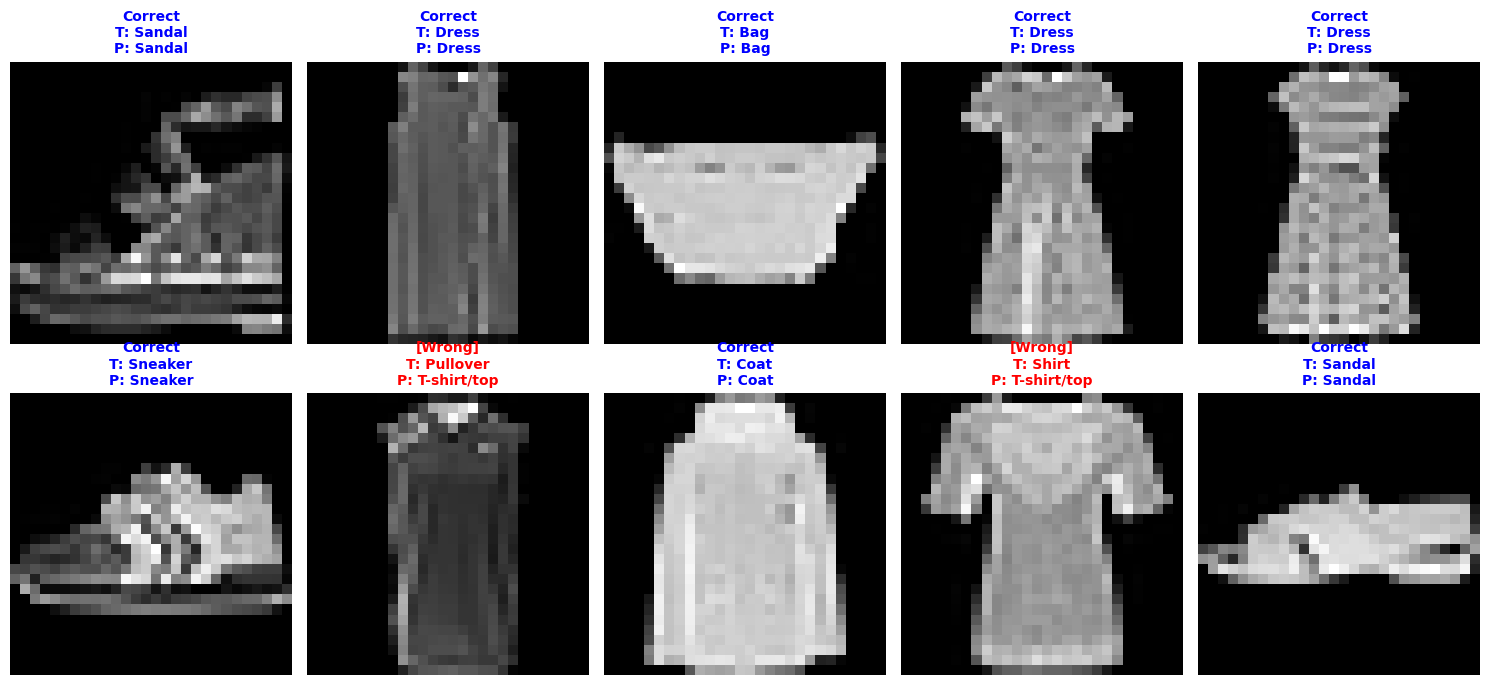

In [41]:
f_mnist_test_images, _, _ = get_fashion_mnist_test_data(mean, std)
visualize_predictions(model, f_mnist_test_images, test_trans, device, mean, std, CHECKPOINT_FILE_PATH)

## 오답 분석 (Wrong Prediction Analysis)

### 오답 케이스 분석

위 시각화 결과에서 빨간색으로 표시된 오답 케이스를 분석합니다:

**분석 템플릿:**

1. **오답 케이스 #1**:
   - **추론된 이유**:
     - Shirt와 T-shirt/top은 시각적으로 매우 유사하여 모델이 혼동할 수 있습니다.
     - 학습 데이터에서 해당 클래스의 변형이 충분하지 않았을 가능성이 있습니다.

2. **오답 케이스 #2**:
   - **추론된 이유**:
     - Pullover와 Coat는 형태가 비슷하여 구분이 어려웠을 것으로 추정됩니다.

### 개선 방안
- 혼동하기 쉬운 클래스 간의 추가 학습
- 모델의 깊이나 복잡도 증가
- 앙상블 기법 적용

---

**※ 실제 오답 케이스를 확인한 후, 위 템플릿을 참고하여 구체적인 분석 내용을 작성하세요.**

## 최종 결과 요약

In [42]:
print("\n" + "=" * 70)
print("FINAL SUMMARY")
print("=" * 70)
print(f" Model       : Wider CNN (3 Blocks, 256 Channels)")
print(f" Params      : LR={args.learning_rate}, Batch={args.batch_size}, Drop={args.dropout_p}")
print(f" Result      : Test Acc {test_acc:.2f}%")
print(f" WandB URL   : {wandb.run.url if wandb.run else 'Disabled'}")
print("=" * 70)

wandb.finish()


FINAL SUMMARY
 Model       : Wider CNN (3 Blocks, 256 Channels)
 Params      : LR=0.0005, Batch=128, Drop=0.5
 Result      : Test Acc 93.99%
 WandB URL   : https://wandb.ai/changyeony-koreatech/Homework_3/runs/9pk2y639


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Learning Rate,█████████▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test accuracy (%),▁
Training accuracy (%),▁▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
Training loss,█▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy (%),▁▁▃▄▅▅▆▆▄▇▆▇▇▆▇▇▇██▇▇▇██████████████████
Validation loss,██▇▅▄▃▃▃▅▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂
Epoch,47
Learning Rate,3e-05
Test accuracy (%),93.99
Training accuracy (%),98.77804


# 숙제 후기

'Test Accuracy 94%' 이상이 목표인 줄 알고 맨땅에 헤딩을 정말 많이 했습니다. 나중에 다시 보니 Validation Accuracy가 기준이었더라고요. 덕분에 0.1%의 정확도를 올리기 위한 '지옥의 튜닝'을 경험했습니다.

처음에는 "왜 안 오르지?" 하고 답답하기만 했는데, 수십 번 실험을 돌리다 보니 감이 잡히기 시작했습니다.
모델을 복잡하게 만들면 학습은 잘하는데 바로 과적합이 오고, 그걸 잡겠다고 모델을 작게 만들고 튜닝하다보면 모델 정확도가 떨어졌습니다.

Fashion MNIST에서 마의 94% 벽을 넘기 위해 제가 시도했던 삽질과 깨달음의 과정은 다음과 같습니다.
처음엔 욕심 안 부리고 32-64-128 채널로 가볍게 시작했습니다. 그런데 StepLR에 데이터 증강까지 다 했는데도 TEST accuracy 93.85%에서 점수가 더이 이상 오르지 않았습니다.
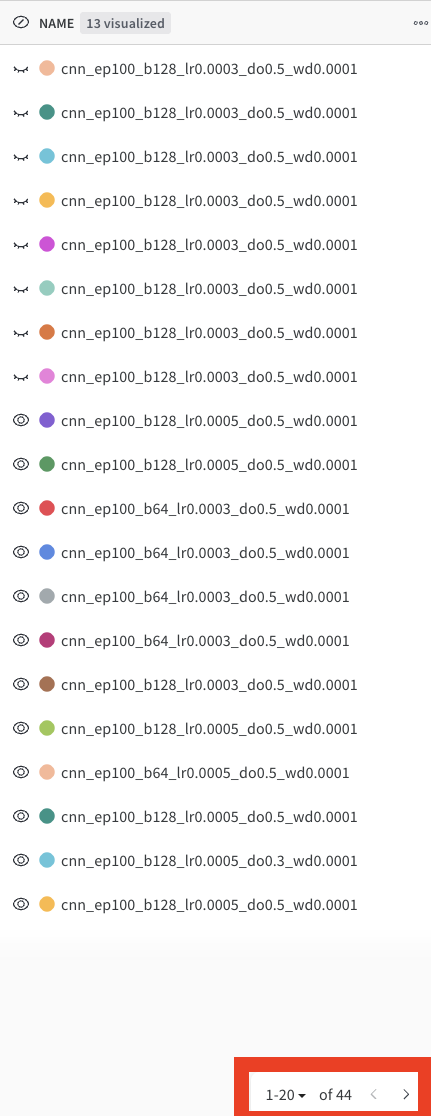

Dropout도 바꿔보고 별짓을 다 해도 안 오르는 걸 보고 단순히 설정값들을 바꿀 것이 아니라, 모델을 조금 수정해야겠다는 결론이 났습니다.

그래서 모델 파라미터를 4배 가까이 늘려서 64-128-256 채널의 모델을 만들었습니다.바꾸자마자 93.99%를 찍었습니다. 근데 모델이 커지니까 훈련 데이터만 달달 외우기 시작한것 같았습니다. 훈련 점수랑 검증 점수 차이가 3% 넘게 벌어졌습니다.

커진 모델에서 과적합을 잡기 위해서 여러 파라미터를 바꾸는 시도를 했고, dropout에서 효과가 있었습니다.
기존엔 Dropout 0.4였는데 과감하게 0.5로 올렸습니다. 욕심나서 학습률도 낮춰보고 L2 규제도 더 걸어봤는데 오히려 점수가 떨어지는 걸 보고, "충분히 큰 모델 + 적당히 강한 Dropout" 이 조합이 정답이란 걸 찾았습니다.

과제를 다 마치고, 수업을 듣는데 ResNet 처럼 또 다른 것을 배우까 아 저거 썼으면 '딸깍' 하고 끝났을 수도 있었겠다 싶었습니다. 그래도 CNN으로 0.01%씩 쥐어짜 보는 경험은 재밌었습니다.